In [730]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import re

from tqdm import tqdm

random_state = 12345

import json
import os

In [731]:
train_ds = pd.read_csv('data/train_dataset.csv')
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37224 entries, 0 to 37223
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          37224 non-null  object 
 1   time          37224 non-null  int64  
 2   target        37224 non-null  float64
 3   temp          37224 non-null  float64
 4   temp_pred     37136 non-null  float64
 5   weather_pred  37136 non-null  object 
 6   weather_fact  37223 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 2.0+ MB


In [732]:
test_ds = pd.read_csv('data/test_dataset.csv')
train_ds = pd.concat([train_ds, test_ds])
train_ds

,date,time,target,temp,temp_pred,weather_pred,weather_fact
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"
...,...,...,...,...,...,...,...
2923,2023-07-31,19,453.173,17.2,18.0,"пасм, 24% дождь",п/обл
2924,2023-07-31,20,446.287,17.2,18.0,"пасм, 24% дождь",п/обл
2925,2023-07-31,21,444.373,15.8,17.0,"пасм, 24% дождь",п/обл
2926,2023-07-31,22,449.078,15.8,17.0,"пасм, 24% дождь",п/обл


In [733]:
test_ds

,date,time,target,temp,temp_pred,weather_pred,weather_fact
0,2023-04-01,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
1,2023-04-01,1,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2,2023-04-01,2,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
3,2023-04-01,3,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
4,2023-04-01,4,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
...,...,...,...,...,...,...,...
2923,2023-07-31,19,453.173,17.2,18.0,"пасм, 24% дождь",п/обл
2924,2023-07-31,20,446.287,17.2,18.0,"пасм, 24% дождь",п/обл
2925,2023-07-31,21,444.373,15.8,17.0,"пасм, 24% дождь",п/обл
2926,2023-07-31,22,449.078,15.8,17.0,"пасм, 24% дождь",п/обл


In [734]:
train_ds['date'] = pd.to_datetime(train_ds['date'])
train_ds['year'] = train_ds['date'].dt.year
train_ds['month'] = train_ds['date'].dt.month
train_ds['day_of_week'] = train_ds['date'].dt.dayofweek
train_ds['day'] = train_ds['date'].dt.day
train_ds['day_of_year'] = train_ds['date'].dt.dayofyear

In [735]:
# функция формирует колонки 'cloudy', 'rainy', 'windy', 'clear', 'some_number'
# в колонках число, которое 0 при отсутсвии упоминания явления в weather_pred или степень упоминания
# функция дает в колонках номер первого списка, элемент которого есть в строке плюс 1
# списки cloudy_list, rainy_list, windy_list, clear_list можно модифицировать
# соответственно, можно экспериментировать с расположением значений в списках
# например, сейчас 'дождь', 'снег', 'д+сн' - первая степень  дождя, а 'гроз', 'ливень' - вторая
# а можно сделать снег второй, а грозу с ливнем убрать в третью
# также сделал отдельный список для "ясности", чтобы выделить 'ясно' и 'солнечно'

def in_what_list(weather, big_list):
    for list_number, small_list in enumerate(big_list):
        if any(word in weather for word in small_list):
            return list_number+1
    return 0

def weather_split2(row):
    weather = row['weather_pred']
    cloudy_list = [['проясн', 'пер.об.', 'п/об'], ['пасм', 'обл']]
    rainy_list = [['дождь', 'снег', 'д+сн'], ['гроз', 'ливень']]
    windy_list = [['вет'],['штор']]
    clear_list = [['проясн'], ['ясно'], ['солнеч']]
    numbers = re.findall(r'\d+', weather)
    cloudy = in_what_list(weather, cloudy_list)
    rainy = in_what_list(weather, rainy_list)
    windy = in_what_list(weather, windy_list)
    clear = in_what_list(weather, clear_list)
    rain_probability = 0 if len(numbers)==0 else int(numbers[0])
    has_rain_probability = int(len(numbers)==0)
    return cloudy, rainy, windy, clear, rain_probability, has_rain_probability

def fill_weather_columns(df):
    df['weather_pred'] = df['weather_pred'].fillna('')
    df['cloudy'], df['rainy'], df['windy'], df['clear'], df['rain_probability'], df['has_rain_probability'] = \
                zip(*df.apply(weather_split2, axis=1))
    return df

train_ds = fill_weather_columns(train_ds)



In [736]:
def sunrise(df):
    latitude = 54.7065
    longitude = 20.511

    sun = Sun(latitude, longitude)

    df['day'] = df.index
    df['sunrise'] = ('2019-01-01 00:00:00')
    df['sunset'] = ('2019-01-01 00:00:00')

    for i in range(len(df_train_orig['day'])):
        df['sunrise'][i] = (sun.get_local_sunrise_time(datetime.date(df['day'][i])) 
                                        - timedelta(hours=1)).strftime('%Y-%m-%dZ%H:%M:%S')
        df['sunset'][i] = (sun.get_local_sunset_time(datetime.date(df['day'][i])) 
                                        - timedelta(hours=1)).strftime('%Y-%m-%dZ%H:%M:%S')
    
    df = df.drop(['day'], axis= 1)

    df['sunset'] = pd.to_datetime(df['sunset'], format='%Y-%m-%dZ%H:%M:%S')
    df['sunrise'] = pd.to_datetime(df['sunrise'], format='%Y-%m-%dZ%H:%M:%S')
    df['sun_time'] = df['sunset'] - df['sunrise']
         
    return df

In [737]:
daylight_2020 = pd.read_csv('data/daylight_data_2020.csv', sep=';').reset_index()
daylight_2020.head(10)
daylight_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           366 non-null    float64
 1   Восход                          366 non-null    object 
 2   Зенит                           366 non-null    object 
 3   Закат                           366 non-null    object 
 4   Долгота дня                     366 non-null    object 
 5   Unnamed: 4                      366 non-null    object 
 6   Начало астрономических сумерек  366 non-null    object 
 7   Начало навигационных сумерек    366 non-null    object 
 8   Начало гражданских сумерек      366 non-null    object 
 9   Конец гражданских сумерек       366 non-null    object 
 10  Конец навигационных сумерек     366 non-null    object 
 11  Конец астрономических сумерек   366 non-null    object 
dtypes: float64(1), object(11)
memory usa

In [738]:
def split_hm_time(s):
    v = s.split(':')
    #return( pd.to_timedelta(int(v[0]), unit='h') + pd.to_timedelta(int(v[1]), unit='m'))
    return( int(v[0])*60 + int(v[1]))

def split_time(s, units):
    v = s.split(':')
    return( sum( [ pd.to_timedelta(int(val), unit=units[i]) for i,val in enumerate(v) ], datetime.timedelta() ) )

split_time('10:10', 'hm')

Timedelta('0 days 10:10:00')

In [739]:
years = [2019, 2020, 2021, 2022, 2023]
daylight_column_names = ['date', 'sunrise', 'midday', 'sunset', 'duration', 'difference', 
                         'astro_sunrise', 'navigational_sunrise', 'civil_sunrise',
                         'civil_sunset', 'navigational_sunset', 'astro_sunset']
daylight_non_hm_names = ['date', 'duration', 'difference']
daylight_hm_names = daylight_column_names.copy()
for name in daylight_non_hm_names:
    daylight_hm_names.remove(name)
daylight_table = []
for i, year in enumerate(years):
    daylight_table.append(pd.read_csv(f'data/daylight_data_{year}.csv', sep=';').reset_index())
    daylight_table[i].columns = daylight_column_names
    daylight_table[i]['date'] = daylight_table[i]['date'].apply(lambda x: '{0:04d}-{1:02d}-{2:02d}'.format(year, round( (x % 1)*100), int(x)))
    daylight_table[i]['date'] = pd.to_datetime(daylight_table[i]['date'])
    #for column in daylight_column_names[1:]:
        #daylight_table[i][column] = pd.to_timedelta(daylight_table[i][column])
    #daylight_table[i]['sunrise'] = pd.to_timedelta(daylight_table[i]['sunrise'], unit='m')

    #daylight_table[i]['sunrise'] = daylight_table[i]['sunrise'].apply(split_hm_time)
    for name in daylight_hm_names:
        daylight_table[i][name] = daylight_table[i][name].where(daylight_table[i][name]!='—', '0:0').apply(split_hm_time)

daylight_df = pd.concat(daylight_table)

daylight_df['civil_day'] = daylight_df['civil_sunset'] - daylight_df['civil_sunrise']
daylight_df['day_duration'] = daylight_df['sunset'] - daylight_df['sunrise']

daylight_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1665 entries, 0 to 203
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1665 non-null   datetime64[ns]
 1   sunrise               1665 non-null   int64         
 2   midday                1665 non-null   int64         
 3   sunset                1665 non-null   int64         
 4   duration              1665 non-null   object        
 5   difference            1665 non-null   object        
 6   astro_sunrise         1665 non-null   int64         
 7   navigational_sunrise  1665 non-null   int64         
 8   civil_sunrise         1665 non-null   int64         
 9   civil_sunset          1665 non-null   int64         
 10  navigational_sunset   1665 non-null   int64         
 11  astro_sunset          1665 non-null   int64         
 12  civil_day             1665 non-null   int64         
 13  day_duration       

In [740]:
# все числа даны в минутах от начала суток
daylight_df.head()

,date,sunrise,midday,sunset,duration,difference,astro_sunrise,navigational_sunrise,civil_sunrise,civil_sunset,navigational_sunset,astro_sunset,civil_day,day_duration
0,2019-01-01,542,762,982,07:19:58,+1:14,406,450,497,1027,1074,1117,530,440
1,2019-01-02,542,762,983,07:21:19,+1:21,406,450,497,1028,1074,1118,531,441
2,2019-01-03,541,763,984,07:22:46,+1:27,406,450,497,1029,1075,1119,532,443
3,2019-01-04,541,763,985,07:24:21,+1:35,406,450,497,1030,1077,1120,533,444
4,2019-01-05,541,764,987,07:26:03,+1:42,406,450,497,1031,1078,1121,534,446


In [741]:
daylight_columns_for_merge = ['date', 'sunrise', 'midday', 'sunset', 'day_duration', 'civil_day']
train_ds = train_ds.merge(daylight_df[daylight_columns_for_merge], on='date')

In [742]:
train_ds.columns

Index(['date', 'time', 'target', 'temp', 'temp_pred', 'weather_pred',
       'weather_fact', 'year', 'month', 'day_of_week', 'day', 'day_of_year',
       'cloudy', 'rainy', 'windy', 'clear', 'rain_probability',
       'has_rain_probability', 'sunrise', 'midday', 'sunset', 'day_duration',
       'civil_day'],
      dtype='object')

In [743]:
train_ds.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact,year,month,day_of_week,...,rainy,windy,clear,rain_probability,has_rain_probability,sunrise,midday,sunset,day_duration,civil_day
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,1,0,0,1,542,762,982,440,530
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,1,0,0,1,542,762,982,440,530
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,1,0,0,1,542,762,982,440,530
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0,1,0,0,1,542,762,982,440,530
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0,1,0,0,1,542,762,982,440,530


In [744]:
df_holidays = pd.read_csv('data/holidays.csv')
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

In [745]:
# Assuming df_holidays and train_ds are your dataframes
train_ds = pd.merge(train_ds, df_holidays, on='date', how='left')

# Fill NaN values with 0
train_ds['holidays'].fillna(0, inplace=True)
train_ds['preholidays'].fillna(0, inplace=True)

# Convert to int
train_ds['holidays'] = train_ds['holidays'].astype(int)
train_ds['preholidays'] = train_ds['preholidays'].astype(int)

In [746]:
train_ds.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact,year,month,day_of_week,...,clear,rain_probability,has_rain_probability,sunrise,midday,sunset,day_duration,civil_day,holidays,preholidays
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,0,1,542,762,982,440,530,0,0
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,0,1,542,762,982,440,530,0,0
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,0,1,542,762,982,440,530,0,0
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0,0,1,542,762,982,440,530,0,0
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0,0,1,542,762,982,440,530,0,0


In [747]:
# создаем столбец 'temp_last_day'
train_ds['temp_last_day'] = train_ds['temp'].shift(24)

# заполняем пропущенные значения в 'temp_last_day'
train_ds['temp_last_day'].fillna(method='bfill', inplace=True)

# создаем столбцы с временными лагами для 'target'
lags = [24, 48, 72, 7*24, 14*24]
for lag in lags:
    train_ds[f'target_lag_{lag}'] = train_ds['target'].shift(lag)

# заполняем пропущенные значения в столбцах с лагами
for lag in lags:
    train_ds[f'target_lag_{lag}'].fillna(0, inplace=True)

In [748]:
# создаем столбец 'temp_last_day'
#train_ds['avg_temp_last_day'] = train_ds.groupby(by='date')['temp_pred'].transform('mean')
#train_ds['max_temp_last_day'] = train_ds.groupby(by='date')['temp_pred'].transform('max')
#train_ds['min_temp_last_day'] = train_ds.groupby(by='date')['temp_pred'].transform('min')
#df.groupby('dummy')['returns'].agg(Mean='mean', Sum='sum')
print(len(train_ds))
#date_temp = train_ds.groupby(by='date')['temp'].agg(avg_temp_last_day='mean', max_temp_last_day='max', min_temp_last_day='min').shift(1)
date_temp = train_ds.groupby(by='date')['temp'].agg(max_temp_last_day='max', min_temp_last_day='min').shift(1)
#train_ds = train_ds.merge(date_temp, on='date')[train_ds['date']>'2019-01-01']
print(len(train_ds))
train_ds.info()

42816
42816
<class 'pandas.core.frame.DataFrame'>
Int64Index: 42816 entries, 0 to 42815
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  42816 non-null  datetime64[ns]
 1   time                  42816 non-null  int64         
 2   target                42816 non-null  float64       
 3   temp                  42816 non-null  float64       
 4   temp_pred             42704 non-null  float64       
 5   weather_pred          42816 non-null  object        
 6   weather_fact          42815 non-null  object        
 7   year                  42816 non-null  int64         
 8   month                 42816 non-null  int64         
 9   day_of_week           42816 non-null  int64         
 10  day                   42816 non-null  int64         
 11  day_of_year           42816 non-null  int64         
 12  cloudy                42816 non-null  int64         
 13  rain

In [749]:
def add_vvp(dataframe, col_date ='date', file_source = 'data/VVP.csv'):
    """
    передаем датафрейм и название колонки с датой, к которой идет привязка ВВП
    формат колонки с датой должен быть datetime64 и с часами
    """
    # читаем файл с динамикой ВВП
    vvp = pd.read_csv(file_source)
    # преобразуем дату файла-источника в формат datetime64 и дропнем один столбик
    vvp['date'] = pd.to_datetime(vvp['date'], format ='%Y-%m-%d %H:%M:%S')
    vvp.drop('for_month',axis=1,inplace=True) 
    # соединяем основной фрейм и ВВП по дате объявления показтеля ВВП
    result = pd.merge(dataframe,vvp,how ='left', on='date')
    # считаем, что пока нет новостей, то берем старые данные
    result['VVP_perc'].fillna(method = 'ffill',inplace=True)
    # для начала датасета берем показатель ВВП из 2018 года вручную
    result['VVP_perc'].fillna(value = vvp['VVP_perc'].iloc[-1]
                              ,inplace=True  )
    # возращаем новый датасет 
    return result

In [750]:
# пример работы
#data = pd.read_csv('data/train_dataset.csv')
#data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d' )
# соединяем дату и часы в один datatime 
def date_plus_hours_to_index(data):
    data = data.copy()
    data['date'] = data['date'] + pd.to_timedelta(data['time'] , 'H')
    data = data.set_index('date')
    return data
# применяем функцию добавления ВВП
train_ds = add_vvp(train_ds,'date')

In [751]:
df_true_weather

,date_tw,P,U,WW,Td,N,S,W,E
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
82146,2023-09-29 21:30:00,761.2,78.0,0.0,15.0,0.0,0.5,1.0,0.0
82147,2023-09-29 22:00:00,761.2,88.0,0.0,16.0,0.0,0.5,1.0,0.0
82148,2023-09-29 22:30:00,761.2,88.0,2.0,16.0,0.0,1.0,0.0,0.0
82149,2023-09-29 23:00:00,761.2,88.0,2.0,16.0,0.0,1.0,0.0,0.0


In [752]:
def true_weather_WW_replace(ww):
    if ww=='нет осадков':
        return 0
    elif ww=='слабый дождь':
        return 1
    elif (ww=='сильный дождь') or (ww=='снег'):
        return 2
    else:
        return 3
#df_true_weather['WW'].unique()

In [753]:
def row_plus_hours_to_index(row):
    return row['date'] + pd.to_timedelta(row['time'] , 'H')

# Функция для сдвига на суткм (в скаченном датасете разбивка по 30 мин, по этому timeshift=48)
def shift_features_fact(df, timeshift=48):
    list_fact_columns=list([df.columns])
    new_df = df.copy()
    for column in list_fact_columns:
        new_df[column] = new_df[column].shift(timeshift)

    return new_df

df_true_weather = pd.read_csv('data/preprocessing_loaded_table.csv')
df_true_weather['WW'] = df_true_weather['WW'].apply(true_weather_WW_replace)
df_true_weather['date'] = pd.to_datetime(df_true_weather['date'])
df_true_weather = df_true_weather.rename(columns={'date':'date_tw'})
df_true_weather = shift_features_fact(df_true_weather)
train_ds['date_hours'] = train_ds.apply(row_plus_hours_to_index, axis=1)
train_ds = train_ds.merge(df_true_weather, left_on='date_hours', right_on='date_tw')
train_ds = train_ds.drop(['date_hours', 'date_tw'], axis=1)

In [754]:
train_ds.columns

Index(['date', 'time', 'target', 'temp', 'temp_pred', 'weather_pred',
       'weather_fact', 'year', 'month', 'day_of_week', 'day', 'day_of_year',
       'cloudy', 'rainy', 'windy', 'clear', 'rain_probability',
       'has_rain_probability', 'sunrise', 'midday', 'sunset', 'day_duration',
       'civil_day', 'holidays', 'preholidays', 'temp_last_day',
       'target_lag_24', 'target_lag_48', 'target_lag_72', 'target_lag_168',
       'target_lag_336', 'VVP_perc', 'P', 'U', 'WW', 'Td', 'N', 'S', 'W', 'E'],
      dtype='object')

In [755]:
df_true_weather

,date_tw,P,U,WW,Td,N,S,W,E
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
82146,2023-09-29 21:30:00,761.2,78.0,0.0,15.0,0.0,0.5,1.0,0.0
82147,2023-09-29 22:00:00,761.2,88.0,0.0,16.0,0.0,0.5,1.0,0.0
82148,2023-09-29 22:30:00,761.2,88.0,2.0,16.0,0.0,1.0,0.0,0.0
82149,2023-09-29 23:00:00,761.2,88.0,2.0,16.0,0.0,1.0,0.0,0.0


In [756]:
train_ds.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact,year,month,day_of_week,...,target_lag_336,VVP_perc,P,U,WW,Td,N,S,W,E
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0.0,1.8,765.0,87.0,0.0,0.0,0.0,1.0,0.5,0.0
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0.0,1.8,763.5,81.0,0.0,0.0,0.0,1.0,1.0,0.0
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0.0,1.8,762.8,87.0,1.0,1.0,0.0,1.0,1.0,0.0
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0.0,1.8,761.2,93.0,1.0,2.0,0.0,1.0,1.0,0.0
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0.0,1.8,759.7,93.0,1.0,3.0,0.0,1.0,1.0,0.0


In [829]:
feature_cols = list(train_ds.columns)
#daylight_columns_for_merge = ['date', 'sunrise', 'midday', 'sunset', 'day_duration', 'civil_day']
#drop_list = ['target', 'date', 'day_of_year', 'weather_pred', 'weather_fact', 'temp', 'sunrise', 'midday', 'sunset']

#выбрасываем взгляд в прошлое и расшифрованную погоду
drop_list = ['target', 'day_of_year', 'weather_pred', 'weather_fact', 'temp']

#выбрасываем световой день, с ним не получилось
drop_list = drop_list+ ['sunrise', 'midday', 'sunset', 'day_duration', 'civil_day']

#выбрасываем признаки, найденные процедурно
drop_list = drop_list + ['target_lag_48', 'target_lag_168', 'target_lag_336'] 

for name in drop_list:
    feature_cols.remove(name)

feature_cols

['date',
 'time',
 'temp_pred',
 'year',
 'month',
 'day_of_week',
 'day',
 'cloudy',
 'rainy',
 'windy',
 'clear',
 'rain_probability',
 'has_rain_probability',
 'holidays',
 'preholidays',
 'temp_last_day',
 'target_lag_24',
 'target_lag_72',
 'VVP_perc',
 'P',
 'U',
 'WW',
 'Td',
 'N',
 'S',
 'W',
 'E']

In [830]:
features = train_ds[feature_cols]
target = train_ds['target']

In [831]:
features.head()

,date,time,temp_pred,year,month,day_of_week,day,cloudy,rainy,windy,...,target_lag_72,VVP_perc,P,U,WW,Td,N,S,W,E
0,2019-01-01,0,2.0,2019,1,1,1,2,0,1,...,0.0,1.8,765.0,87.0,0.0,0.0,0.0,1.0,0.5,0.0
1,2019-01-01,1,2.0,2019,1,1,1,2,0,1,...,0.0,1.8,763.5,81.0,0.0,0.0,0.0,1.0,1.0,0.0
2,2019-01-01,2,2.0,2019,1,1,1,2,0,1,...,0.0,1.8,762.8,87.0,1.0,1.0,0.0,1.0,1.0,0.0
3,2019-01-01,3,2.0,2019,1,1,1,2,0,1,...,0.0,1.8,761.2,93.0,1.0,2.0,0.0,1.0,1.0,0.0
4,2019-01-01,4,2.0,2019,1,1,1,2,0,1,...,0.0,1.8,759.7,93.0,1.0,3.0,0.0,1.0,1.0,0.0


In [876]:
features[ features['day_of_week']>=5 ]

,date,time,temp_pred,year,month,day_of_week,day,cloudy,rainy,windy,...,target_lag_72,VVP_perc,P,U,WW,Td,N,S,W,E
96,2019-01-05,0,3.0,2019,1,5,5,2,1,0,...,465.381,1.8,756.9,100.0,1.0,3.0,0.0,0.0,1.0,0.0
97,2019-01-05,1,3.0,2019,1,5,5,2,1,0,...,437.692,1.8,756.9,93.0,1.0,3.0,0.5,0.0,1.0,0.0
98,2019-01-05,2,3.0,2019,1,5,5,2,1,0,...,416.416,1.8,756.2,100.0,1.0,4.0,0.5,0.0,1.0,0.0
99,2019-01-05,3,4.0,2019,1,5,5,2,1,0,...,401.808,1.8,756.2,93.0,1.0,3.0,0.5,0.0,1.0,0.0
100,2019-01-05,4,4.0,2019,1,5,5,2,1,0,...,394.554,1.8,755.4,93.0,1.0,3.0,1.0,0.0,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42683,2023-07-23,19,18.0,2023,7,6,23,2,1,0,...,443.907,-3.6,756.2,94.0,2.0,16.0,0.5,0.0,1.0,0.0
42684,2023-07-23,20,18.0,2023,7,6,23,2,1,0,...,437.656,-3.6,756.2,94.0,2.0,16.0,0.5,0.0,1.0,0.0
42685,2023-07-23,21,18.0,2023,7,6,23,2,1,0,...,432.884,-3.6,756.2,94.0,2.0,15.0,0.0,0.0,1.0,0.0
42686,2023-07-23,22,18.0,2023,7,6,23,2,1,0,...,442.715,-3.6,756.2,100.0,2.0,15.0,0.0,0.0,0.0,0.0


In [879]:
def features_split(features, target, date):
    features_train = features[features['date']<date]
    target_train = target[features_train.index]
    features_valid = features[features['date']>=date]
    target_valid = target[features_valid.index]
    features_train = features_train.drop('date', axis=1)
    features_valid = features_valid.drop('date', axis=1)
    return features_train, features_valid, target_train, target_valid


In [880]:
def features_interval(features, target, date1, date2):
    features_interval = features[ (features['date']>=date1) & (features['date']<date2) ]
    target_interval = target[features_interval.index]
    features_interval = features_interval.drop('date', axis=1)
    return features_interval, target_interval

In [878]:
def features_interval_augment(features, target, date1, date2, add_weekends = 0):
    features_interval = features[ (features['date']>=date1) & (features['date']<date2) ]
    weekends = features_interval[ features_interval['day_of_week']>=5 ]
    features_interval = pd.concat([features_interval]+[weekends]*add_weekends)
    target_interval = target[features_interval.index]
    features_interval = features_interval.drop('date', axis=1)
    return features_interval, target_interval

In [869]:
features_train, target_train = features_interval(features, target, '2019-01-01', '2022-01-01')
features_valid, target_valid = features_interval(features, target, '2022-01-01', '2023-01-01')

In [837]:
dates = ['2022-01-01', '2022-04-01', '2022-07-01', '2022-10-01', '2023-01-01']
quarters = []
for i in range(4):
    f, t, d = features_interval(features, target, dates[i], dates[i+1])
    quarters.append({'features':f, 'target':t, 'date':d})

In [838]:
def mae_day(y_true, y_pred):
    y_true_copy = pd.DataFrame(y_true).reset_index(drop=True)
    y_true_copy['day'] = y_true_copy.index // 24
    y_true_grouped = y_true_copy.groupby(by='day').sum()   
    y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
    y_pred_copy['day'] = y_pred_copy.index // 24
    y_pred_grouped = y_pred_copy.groupby(by='day').sum()
    
    return mean_absolute_error(y_true_grouped, y_pred_grouped)

In [839]:
# класс предлагается инициализировать, затем брать значения параметра из current_value 
# и регистрировать значения метрики методом add_metric_value, пока add_metric_value не вернет True

# параметры инициализации: 
# initial_values - начальный вектор значений параметра, может быть любой длины
# stop_relation - целевое отношение соседних значений параметра для остановки поиска
# step_method - способ формирования трех точек для первой параболы дугой вниз
# step_method = 'geometric' - делим или умножаем значение с минимальной метрикой на geometric_step
# step_method = 'dichotomy' - делим интервал с минимальной метрикой на границах пополам
# step_method = 'geometric_dichotomy' - делим интервал с минимальной метрикой на границах средним геометрическим

class one_parameter_parabolic_optimizer:
    def __init__(self, initial_values, stop_relation=1.1, step_method='nothing', geometric_step=2):      
        self.data = pd.DataFrame(columns=('parameter','metric','x2','x','1'), dtype='float')
        self.parabolic_mode = False
        self.parabolic_error = False
        self.stop_relation_log = np.log(stop_relation)
        self.initial_values = initial_values            
        self.step_method = step_method                              
        self.geometric_step = geometric_step
        self.initial_counter = 0
        self.current_value = self.initial_values[0]
        
    def best_value(self):
        return self.data.loc[self.data['metric'].idxmin(), 'parameter']
    
# строим параболу через точку с минимальной метрикой и две соседние и ищем ее минимум
    def next_parabolic(self):                      
        self.data['x2'] = self.data['parameter']**2
        self.data['x'] = self.data['parameter']
        self.data['1'] = 1
        self.data = self.data.astype(float).sort_values(by='parameter', ascending=True).reset_index(drop=True)
        index_min = self.data['metric'].idxmin()
        matrix = self.data[['x2','x','1']][index_min-1:index_min+2]
        y = self.data['metric'][index_min-1:index_min+2]
        vector_abc = np.linalg.inv(matrix) @ y
        return -vector_abc[1]/vector_abc[0]/2

    def next_geometric(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return self.data.loc[index_min, 'parameter']/self.geometric_step
        else:
            return self.data.loc[index_min, 'parameter']*self.geometric_step
        
    def next_dichotomy(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return (self.data.loc[index_min, 'parameter'] + self.data.loc[index_min+1, 'parameter'])/2
        else:
            return (self.data.loc[index_min, 'parameter'] + self.data.loc[index_min-1, 'parameter'])/2
        
    def next_geometric_dichotomy(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return (self.data.loc[index_min, 'parameter'] * self.data.loc[index_min+1, 'parameter'])**0.5
        else:
            return (self.data.loc[index_min, 'parameter'] * self.data.loc[index_min-1, 'parameter'])**0.5
    
    def add_metric_value(self, metric_value):
        if self.parabolic_error:           # записана ошибка, выход
                return True
        self.data.loc[self.data.shape[0]] = [self.current_value, metric_value, 0, 0, 0]   # новое значение в таблицу
        if self.initial_counter+1 < len(self.initial_values) :              # если начальные значения не закончились,
            self.initial_counter+=1                                         # то считаем метрику в них
            self.current_value = self.initial_values[self.initial_counter]
            return False
        self.data = self.data.astype(float).sort_values(by='parameter', ascending=True).reset_index(drop=True)
        index_min = self.data['metric'].idxmin()         # ищем минимальную метрику
        parabolic_ready = (index_min!=0) and (index_min!=self.data.shape[0]-1)      # и выясняем, на краю ли она таблицы
        if parabolic_ready:
            self.parabolic_mode = True                               # если не на краю, дальше считаем параболой                  
            self.current_value = self.next_parabolic()
            loglog = abs(np.array([np.log(self.data.loc[index_min-1,'parameter'])-np.log(self.data.loc[index_min,'parameter']),
                              np.log(self.data.loc[index_min+1,'parameter']) -np.log(self.data.loc[index_min,'parameter'])]))            
            return loglog.min() < self.stop_relation_log   # пока не выполним критерий
        elif self.parabolic_mode:    # если уже была парабола, а теперь не получается, то пишем ошибку: метод расходится
            return True
        elif self.step_method == 'geometric': # если еще нет точек для параболы и задана геометрическая прогрессия
            self.current_value = self.next_geometric()
            return False
        elif self.step_method == 'dichotomy': # если еще нет точек для параболы и задана дихотомия 
            self.current_value = self.next_dichotomy()
            return False
        elif self.step_method == 'geometric_dichotomy': # если еще нет точек для параболы и задана geometric_dichotomy 
            self.current_value = self.next_geometric_dichotomy()
            return False
        else: # если еще нет точек для параболы и метод поиска не задан, завершаем
            return True

In [840]:
%%time
optimizer = one_parameter_parabolic_optimizer([0.01], 1.03, step_method='geometric')
for i in range(10):
    learning_rate = optimizer.current_value
    lgbm_model = lgb.LGBMRegressor(num_leaves=15, learning_rate=learning_rate, num_iterations=5000, random_state=random_state, objective='regression_l1', n_jobs=-1)
    lgbm_model.fit(features_train, target_train)
    mae = mae_day(target_valid, lgbm_model.predict(features_valid))
    print(f'learning rate = {learning_rate:.5f} mae = {mae:.1f}')
    if optimizer.add_metric_value(mae):
        break
best_learning_rate_1000 = optimizer.best_value()

c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.01000 mae = 176.6


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.00500 mae = 172.8


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.00250 mae = 172.4


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.00125 mae = 174.9


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.00363 mae = 175.7


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.00236 mae = 177.7


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.00302 mae = 170.8


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.00292 mae = 170.5


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.00287 mae = 164.6
CPU times: total: 3min 35s
Wall time: 1min 46s


In [841]:
%%time
optimizer = one_parameter_parabolic_optimizer([0.2, 1], 1.03, step_method='dichotomy')
for i in range(10):
    feature_fraction = optimizer.current_value
    lgbm_model = lgb.LGBMRegressor(num_leaves=15, learning_rate=best_learning_rate_1000,  
                               num_iterations=5000, 
                               feature_fraction=feature_fraction, random_state=random_state, 
                               objective='regression_l1', n_jobs=-1)
    lgbm_model.fit(features_train, target_train)
    mae = mae_day(target_valid, lgbm_model.predict(features_valid))
    print(f'feature_fraction = {feature_fraction:.5f} mae = {mae:.1f}')
    if optimizer.add_metric_value(mae):
        break
best_feature_fraction = optimizer.best_value()

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.20000 mae = 270.6
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 1.00000 mae = 164.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.60000 mae = 167.6
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.80000 mae = 168.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.90000 mae = 178.2
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.95000 mae = 168.6
[LightGBM] [Warning] feature_fraction is set=0.975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.97500 mae = 168.6
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.98750 mae = 164.6
CPU times: total: 3min 19s
Wall time: 1min 25s


In [842]:
#%%time
#optimizer = one_parameter_parabolic_optimizer([7, 55], 1.03, step_method='geometric_dichotomy')
#for i in range(10):
#    num_leaves = int(optimizer.current_value)
#    lgbm_model = lgb.LGBMRegressor(num_leaves=num_leaves, learning_rate=best_learning_rate_1000,  
#                               num_iterations=5000, 
#                               feature_fraction=best_feature_fraction, random_state=random_state, 
#                               objective='regression_l1', n_jobs=-1)
#    lgbm_model.fit(features_train, target_train)
#    mae = mae_day(target_valid, lgbm_model.predict(features_valid))
#    print(f'num_leaves = {num_leaves:.5f} mae = {mae:.1f}')
#    if optimizer.add_metric_value(mae):
#        break
#best_num_leaves = optimizer.best_value()

In [843]:
lgbm_model = lgb.LGBMRegressor(num_leaves=15, learning_rate=best_learning_rate_1000, num_iterations=10000, 
                               feature_fraction=best_feature_fraction, random_state=random_state, objective='regression_l1', n_jobs=-1)
lgbm_model.fit(features_train, target_train)

[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMRegressor(feature_fraction=0.9875, learning_rate=0.0028674413299018555,
              num_iterations=10000, num_leaves=15, objective='regression_l1',
              random_state=12345)

In [844]:
y_pred = lgbm_model.predict(features_valid)
mae = mae_day(target_valid, y_pred)
print(f'mae_of_the_day - {mae}')
print(f'mae of the hour - {mean_absolute_error(target_valid, y_pred)}')

mae_of_the_day - 163.9949585444689
mae of the hour - 9.28067000282859


In [845]:
y_true_copy = pd.DataFrame(target_valid).reset_index(drop=True)
y_true_copy['day'] = y_true_copy.index // 24
y_true_grouped = y_true_copy.groupby(by='day').sum()   
y_true_grouped
y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
y_pred_copy['day'] = y_pred_copy.index // 24
y_pred_grouped = y_pred_copy.groupby(by='day').sum()

<AxesSubplot:xlabel='day'>

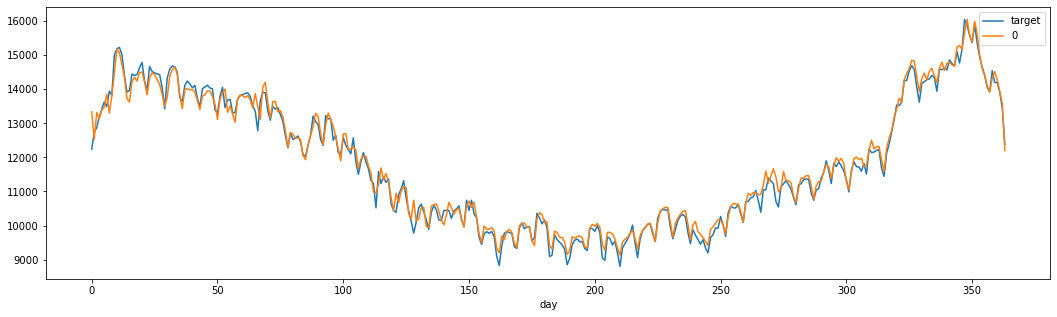

In [846]:
y_true_grouped.plot(figsize=(18,5))
ax=plt.gca()
y_pred_grouped.plot(ax=ax)

<AxesSubplot:xlabel='date'>

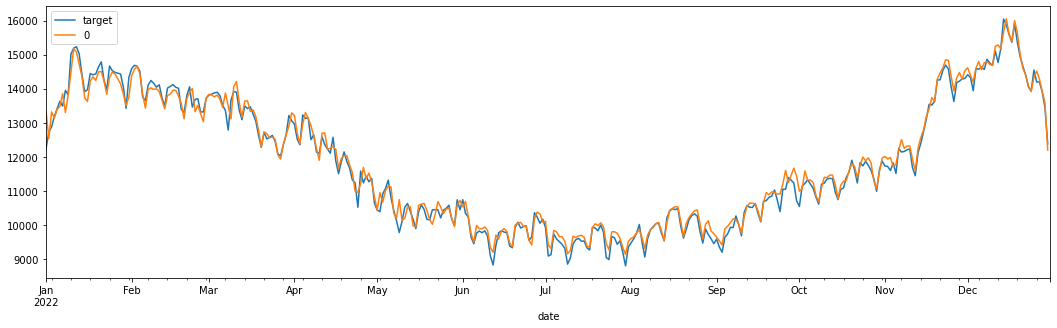

In [871]:
#pd.DataFrame(date_valid)
tmpdf = pd.DataFrame(train_ds.loc[features_valid.index,:]['date']).groupby(by='date').count().reset_index().join(y_true_grouped)
tmpdf.plot(x='date', y='target', figsize=(18,5))
ax=plt.gca()
tmpdf = pd.DataFrame(train_ds.loc[features_valid.index,:]['date']).groupby(by='date').count().reset_index().join(y_pred_grouped)
tmpdf.plot(ax=ax, x='date', y=0)

In [848]:
for quarter in quarters:
    mae = mae_day(quarter['target'], lgbm_model.predict(quarter['features']))
    print(f'mae_of_the_day - {mae}')

mae_of_the_day - 185.9088506981327
mae_of_the_day - 156.63501254873384
mae_of_the_day - 163.91881822317887
mae_of_the_day - 148.10670005666242


In [849]:
features_2023, target_2023 = features_interval(features, target, '2023-01-01', '2023-04-01')
mae = mae_day(target_2023, lgbm_model.predict(features_2023))
print(f'mae_of_the_day - {mae}')

mae_of_the_day - 150.09591094767686


In [850]:
features_2022, target_2022 = features_interval(features, target, '2019-01-01', '2023-01-01')
lgbm_model_2022 = lgb.LGBMRegressor(num_leaves=15, learning_rate=best_learning_rate_1000, num_iterations=10000, 
                               feature_fraction=best_feature_fraction, random_state=random_state, objective='regression_l1', n_jobs=-1)
lgbm_model_2022.fit(features_2022, target_2022)
mae = mae_day(target_2023, lgbm_model_2022.predict(features_2023))
print(f'mae_of_the_day - {mae}')
mae_base = mae

[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


mae_of_the_day - 142.90470238629524


In [851]:
features_all_train, target_all_train, date_all_train = features_interval(features, target, '2019-01-01', '2023-04-01')
lgbm_model_all_train = lgb.LGBMRegressor(num_leaves=15, learning_rate=best_learning_rate_1000, num_iterations=10000, 
                               feature_fraction=best_feature_fraction, random_state=random_state, objective='regression_l1', n_jobs=-1)
lgbm_model_all_train.fit(features_all_train, target_all_train)


features_test, target_test, date_test = features_interval(features, target, '2023-04-01', '2023-08-01')
mae = mae_day(target_test, lgbm_model_all_train.predict(features_test))
print(f'mae_of_the_day - {mae}')

[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


mae_of_the_day - 121.93029658228129


In [852]:
feature_cols_no_date = feature_cols.copy()
feature_cols_no_date.remove('date')
feature_drop_list = []
for feature_name in feature_cols_no_date:
    tmp_train, tmp_valid = features_2022.copy(), features_2023.copy()
    tmp_train = tmp_train.drop(feature_name, axis=1)
    tmp_valid = tmp_valid.drop(feature_name, axis=1)
    lgbm_model_feature_drop = lgb.LGBMRegressor(num_leaves=15, learning_rate=best_learning_rate_1000, num_iterations=10000, 
                               feature_fraction=best_feature_fraction, random_state=random_state, objective='regression_l1', n_jobs=-1)
    lgbm_model_feature_drop.fit(tmp_train, target_2022)
    mae = mae_day(target_2023, lgbm_model_feature_drop.predict(tmp_valid))
    feature_drop_list.append([feature_name, mae])
    print(f'dropped {feature_name} ----------> mae = {mae}')

[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped time ----------> mae = 200.28556265369625
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped temp_pred ----------> mae = 145.7560202510432
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped year ----------> mae = 143.1509201246466
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped month ----------> mae = 150.45846197935043
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped day_of_week ----------> mae = 274.7660306200836
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped day ----------> mae = 151.84902429352638
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped cloudy ----------> mae = 144.1314822965989
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped rainy ----------> mae = 144.70616295882445
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped windy ----------> mae = 141.20069705652716
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped clear ----------> mae = 144.50094421970078
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped rain_probability ----------> mae = 142.4404649553024
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped has_rain_probability ----------> mae = 142.7375727156344
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped holidays ----------> mae = 146.2219012478547
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped preholidays ----------> mae = 142.67158641704174
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped temp_last_day ----------> mae = 148.4378352620158
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped target_lag_24 ----------> mae = 228.767237551167
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped target_lag_72 ----------> mae = 140.00574421732688
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped VVP_perc ----------> mae = 150.33666023516122
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped P ----------> mae = 144.28023132069845
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped U ----------> mae = 150.38539536820417
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped WW ----------> mae = 144.9407774638709
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped Td ----------> mae = 154.45172381422515
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped N ----------> mae = 141.16903069509019
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped S ----------> mae = 143.04569282792767
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped W ----------> mae = 145.6937424940376
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped E ----------> mae = 143.35167438179838


In [853]:
feature_drop_list_df = pd.DataFrame( feature_drop_list, columns=['feature_name','mae_improvement']).sort_values(by='mae_improvement')
feature_drop_list_df['mae_improvement'] = mae_base - feature_drop_list_df['mae_improvement']
feature_drop_list_df.head()

,feature_name,mae_improvement
16,target_lag_72,2.898958
22,N,1.735672
8,windy,1.704005
10,rain_probability,0.464237
13,preholidays,0.233116


In [854]:
print('learning_rate = ', best_learning_rate_1000)
print('feature_fraction = ', best_feature_fraction)

learning_rate =  0.0028674413299018555
feature_fraction =  0.9875


In [855]:
# this was at 2 drops
# learning_rate =  0.00387870312757062
# feature_fraction =  0.9875
# base mae = 148.72177561808167
# test mae = 121.41877699631416

<AxesSubplot:ylabel='0'>

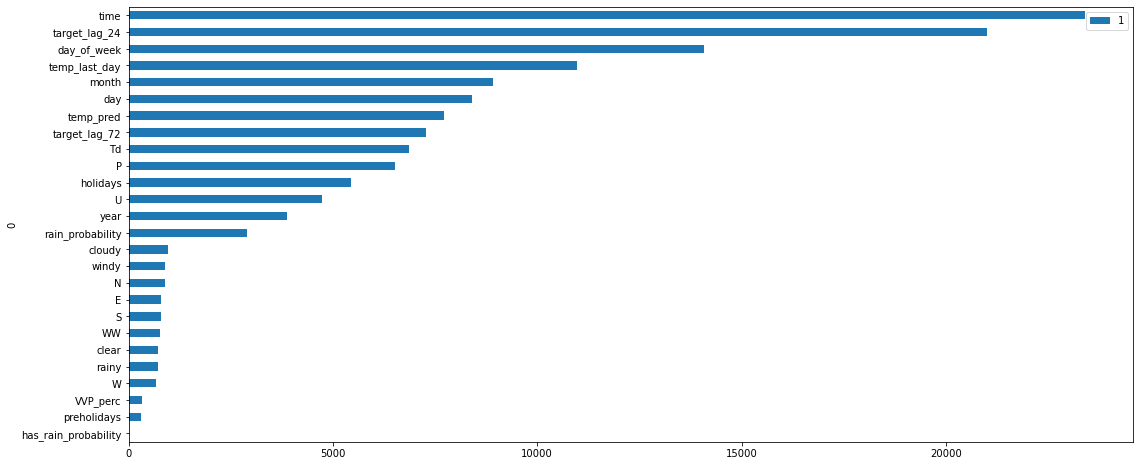

In [856]:
tmp_feature_cols = feature_cols.copy()
tmp_feature_cols.remove('date')
feature_importances = pd.DataFrame([tmp_feature_cols, lgbm_model.feature_importances_]).T.sort_values(by = 1)
feature_importances.plot(kind='barh', x=0, y=1, figsize=(18, 8))